In [81]:
from pathlib import Path

import gzip
import requests

import pandas as pd

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, precision_recall_curve, average_precision_score, roc_curve, auc

In [6]:
def download_credit_card_dataset(skip_if_exists=True):
    target_path = Path('./creditcard.csv.gz')
    if skip_if_exists and target_path.exists():
        return
    
    source_url='https://datahub.io/machine-learning/creditcard/r/creditcard.csv'
    content = requests.get(source_url).content
    
    with gzip.open(target_path, 'wb') as f:
        f.write(content)
    
download_credit_card_dataset()

In [44]:
def load_X_y():
    data = pd.read_csv('./creditcard.csv.gz', quotechar="'")
    X = data.drop('Class', axis=1)
    y = data.Class
    
    return X, y

data_X, data_y = load_X_y()

In [45]:
data_y.value_counts()#.index[0]

0    284315
1       492
Name: Class, dtype: int64

In [46]:
data_y[0]

0

In [47]:
data_X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [48]:
data_y

0         0
1         0
2         0
3         0
4         0
         ..
284802    0
284803    0
284804    0
284805    0
284806    0
Name: Class, Length: 284807, dtype: int64

In [49]:
def standardize_X(X):

    featuresToScale = X.drop('Time', axis=1).columns
    
    X.loc[: , featuresToScale] = StandardScaler(copy=True).fit_transform(X.loc[:, featuresToScale])
    

standardize_X(data_X)
data_X.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,94813.859575,-8.881566e-18,-1.277349e-17,-4.790058e-17,-1.955940e-17,3.832046e-17,9.979288e-18,1.476935e-17,3.293165e-18,9.979288e-20,...,-7.035398e-18,-4.989644e-19,2.794201e-18,9.380530e-18,1.117680e-17,-5.109395e-17,7.946008e-18,1.234937e-18,-6.336848e-18,2.913952e-17
std,47488.145955,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,0.000000,-2.879855e+01,-4.403529e+01,-3.187173e+01,-4.013919e+00,-8.240810e+01,-1.963606e+01,-3.520940e+01,-6.130252e+01,-1.222802e+01,...,-7.069146e+01,-4.741907e+01,-1.506565e+01,-7.175446e+01,-4.683638e+00,-1.975033e+01,-5.401098e+00,-5.590660e+01,-4.674612e+01,-3.532294e-01
25%,54201.500000,-4.698918e-01,-3.624707e-01,-5.872142e-01,-5.993788e-01,-5.010686e-01,-5.766822e-01,-4.478860e-01,-1.746805e-01,-5.853631e-01,...,-2.746334e-01,-3.109433e-01,-7.473476e-01,-2.591784e-01,-5.854676e-01,-6.084001e-01,-6.780717e-01,-1.755053e-01,-1.604440e-01,-3.308401e-01
50%,84692.000000,9.245351e-03,3.965683e-02,1.186124e-01,-1.401724e-02,-3.936682e-02,-2.058046e-01,3.241723e-02,1.871982e-02,-4.681169e-02,...,-8.104705e-02,-4.009429e-02,9.345377e-03,-1.792420e-02,6.765678e-02,3.183240e-02,-1.081217e-01,3.325174e-03,3.406368e-02,-2.652715e-01
75%,139320.500000,6.716939e-01,4.867202e-01,6.774569e-01,5.250082e-01,4.433465e-01,2.991625e-01,4.611107e-01,2.740785e-01,5.435305e-01,...,1.725733e-01,2.537392e-01,7.283360e-01,2.364319e-01,7.257153e-01,6.728006e-01,4.996663e-01,2.255648e-01,2.371526e-01,-4.471707e-02
max,172792.000000,1.253351e+00,1.335775e+01,6.187993e+00,1.191874e+01,2.521413e+01,5.502015e+01,9.747824e+01,1.675153e+01,1.419494e+01,...,5.113464e+01,3.703471e+01,1.447304e+01,3.607668e+01,7.569684e+00,1.442532e+01,7.293975e+00,7.831940e+01,1.025434e+02,1.023622e+02


In [50]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.33, random_state=2018, stratify=data_y)

In [51]:
y_train

142087    0
165168    0
235908    0
148255    0
145672    0
         ..
30023     0
195475    0
48687     0
159608    0
197673    0
Name: Class, Length: 190820, dtype: int64

# Model #1: Logistic Regression

## Training Model #1: Logistic Regression

In [52]:
def make_logreg_model():
    return LogisticRegression(penalty='l2', C=1.0, class_weight='balanced', random_state=2018, solver='liblinear')

logreg_model = make_logreg_model()

In [53]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2018)

In [54]:
logreg_model.__class__.__name__

'LogisticRegression'

In [55]:
def train_model(model, cross_validator):
#    training_scores = []
#    validation_scores = []
    predictions = pd.DataFrame(data=[], index=y_train.index, columns=[0,1])

    for i, (training_index, validation_index) in enumerate(cross_validator.split(X_train, y_train)):
        X_training_fold = X_train.iloc[training_index, :]
        y_training_fold = y_train.iloc[training_index]

        model.fit(X_training_fold, y_training_fold)

        y_training_proba = model.predict_proba(X_training_fold)
        log_loss_training = log_loss(y_true=y_training_fold, y_pred=y_training_proba)

        X_validation_fold = X_train.iloc[validation_index, :]
        y_validation_fold = y_train.iloc[validation_index]

        y_validation_proba = model.predict_proba(X_validation_fold)
        log_loss_validation = log_loss(y_true=y_validation_fold, y_pred=y_validation_proba)

        predictions.loc[X_validation_fold.index, :] = y_validation_proba

#        training_scores.append(log_loss_training)
#        validation_scores.append(log_loss_validation)

        print(f'Cross Validation #Fold={i+1:1}/{cross_validator.n_splits:1} - Training Log Loss: {log_loss_training:.6f} - Validation Log Loss: {log_loss_validation:.6f}')
        
    return predictions

predictions_logreg = train_model(model=logreg_model, cross_validator=stratified_kfold)
log_loss_logreg = log_loss(y_train, predictions_logreg.loc[:, 1])
print(f'{logreg_model.__class__.__name__} Log Loss: {log_loss_logreg:.6f}')

Cross Validation #Fold=1/5 - Training Log Loss: 0.109664 - Validation Log Loss: 0.108788
Cross Validation #Fold=2/5 - Training Log Loss: 0.104602 - Validation Log Loss: 0.104089
Cross Validation #Fold=3/5 - Training Log Loss: 0.115400 - Validation Log Loss: 0.117647
Cross Validation #Fold=4/5 - Training Log Loss: 0.115585 - Validation Log Loss: 0.118171
Cross Validation #Fold=5/5 - Training Log Loss: 0.097081 - Validation Log Loss: 0.096962
LogisticRegression Log Loss: 0.109131


## Evaluation Metrics for Model #1: Logistic Regression

In [56]:
predictions_logreg

,0,1
142087,0.999175,0.000824943
165168,0.968042,0.031958
235908,0.839456,0.160544
148255,0.993092,0.00690756
145672,0.962657,0.0373426
...,...,...
30023,0.748458,0.251542
195475,0.960248,0.0397518
48687,0.981355,0.0186453
159608,0.995289,0.00471132


In [57]:
preds = pd.concat([y_train, predictions_logreg.loc[:, 1]], axis=1).copy()
preds.columns = ['TRUELABEL', 'PREDICTION']
preds

,TRUELABEL,PREDICTION
142087,0,0.000824943
165168,0,0.031958
235908,0,0.160544
148255,0,0.00690756
145672,0,0.0373426
...,...,...
30023,0,0.251542
195475,0,0.0397518
48687,0,0.0186453
159608,0,0.00471132


In [59]:
precision, recall, thresholds = precision_recall_curve(y_true=preds.TRUELABEL, probas_pred=preds.PREDICTION)

In [60]:
average_precision = average_precision_score(y_true=preds.TRUELABEL, y_score=preds.PREDICTION)

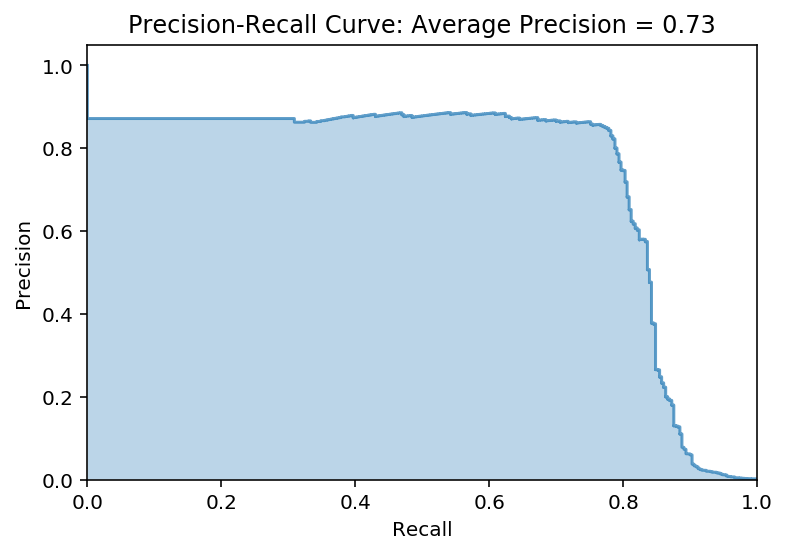

In [93]:
def plot_precision_recall_curve(y_true, probas_pred):
    precision, recall, thresholds = precision_recall_curve(y_true=y_true, probas_pred=probas_pred)
    average_precision = average_precision_score(y_true=y_true, y_score=probas_pred)
    
    plt.step(x=recall, y=precision, where='post', alpha=0.7)
    plt.fill_between(x=recall, y1=precision, step='post', alpha=0.3)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    plt.title(f'Precision-Recall Curve: Average Precision = {average_precision:.02f}')
    
plot_precision_recall_curve(y_true=preds.TRUELABEL, probas_pred=preds.PREDICTION)

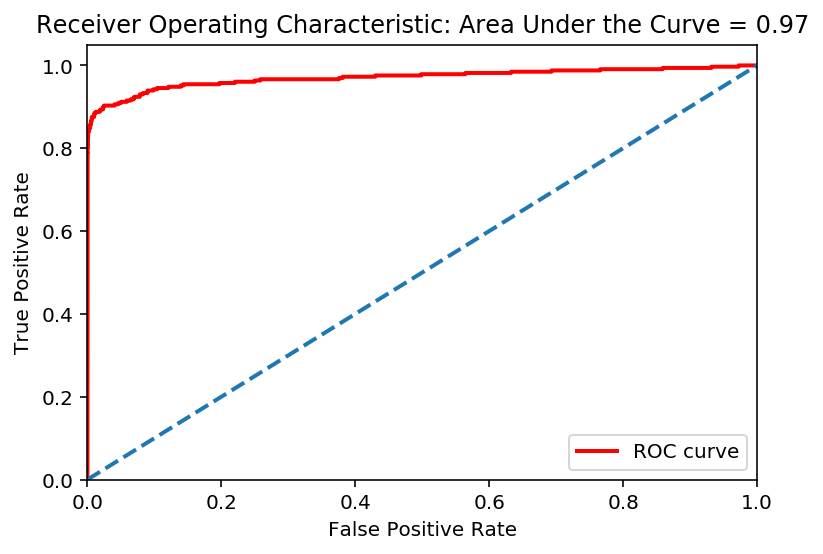

In [96]:
def plot_auroc(y_true, probas_pred):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true=y_true, y_score=probas_pred)
    
    area_under_ROC = auc(x=false_positive_rate, y=true_positive_rate)
    
    plt.plot(false_positive_rate, true_positive_rate, color='r', linewidth='2', label='ROC curve')
    plt.plot([0, 1], [0, 1], linewidth=2, linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title(f'Receiver Operating Characteristic: Area Under the Curve = {area_under_ROC:.02f}')

    plt.legend()
    
plot_auroc(y_true=preds.TRUELABEL, probas_pred=preds.PREDICTION)